In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal
from mpl_toolkits import mplot3d
from scipy.fft import fft


ts = np.loadtxt("elNino.txt", usecols=range(1,13), dtype='float')
print(tempdiff := np.ndarray.flatten(ts))

[-1.   -1.2  -0.83 ... -0.99 -0.76 -0.86]


In [146]:
print(len(tempdiff))

1836


Plot the time series:

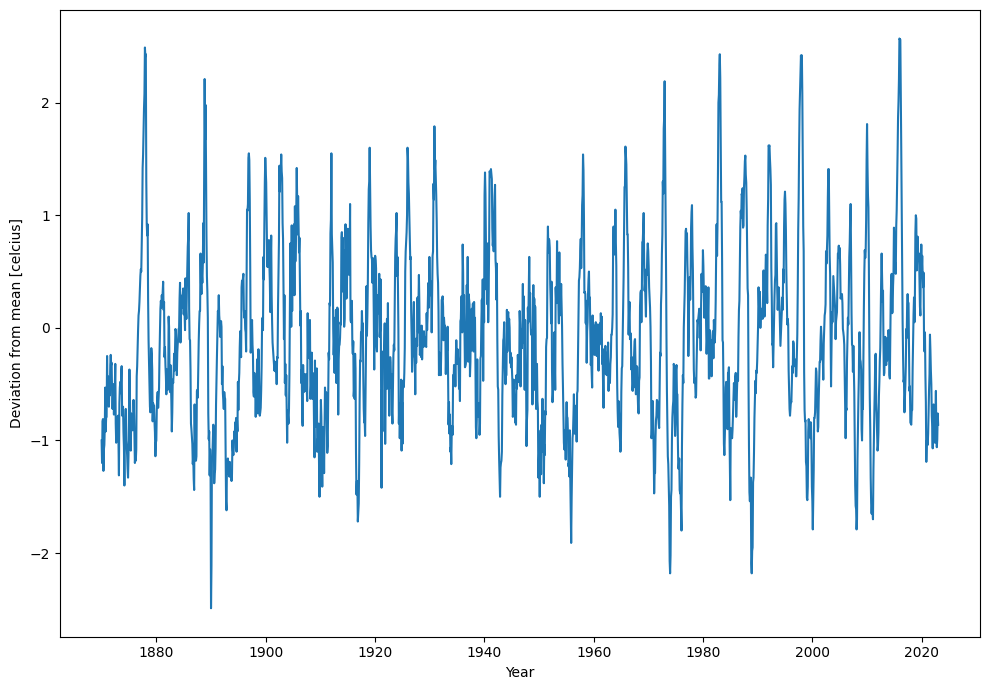

1836


In [132]:
flat_data = tempdiff
t = pd.date_range(start='1870-01-01',
                  end='2022-12-31',
                  periods=len(flat_data))
plt.plot(t, flat_data)
plt.xlabel("Year")
plt.ylabel("Deviation from mean [celcius]")
plt.show()
print(len(flat_data))

In [118]:
def return_map(ts, tau):
    plt.rcParams["figure.figsize"] = [10.00, 7]
    plt.rcParams["figure.autolayout"] = True
    plt.plot(ts[:-(tau)], ts[tau:])
    plt.xlabel("$x(t)$")
    plt.ylabel("$x(t+τ)$")
    plt.title(f"$τ = {tau}$")
    plt.show()


Plot the return map using different lags:

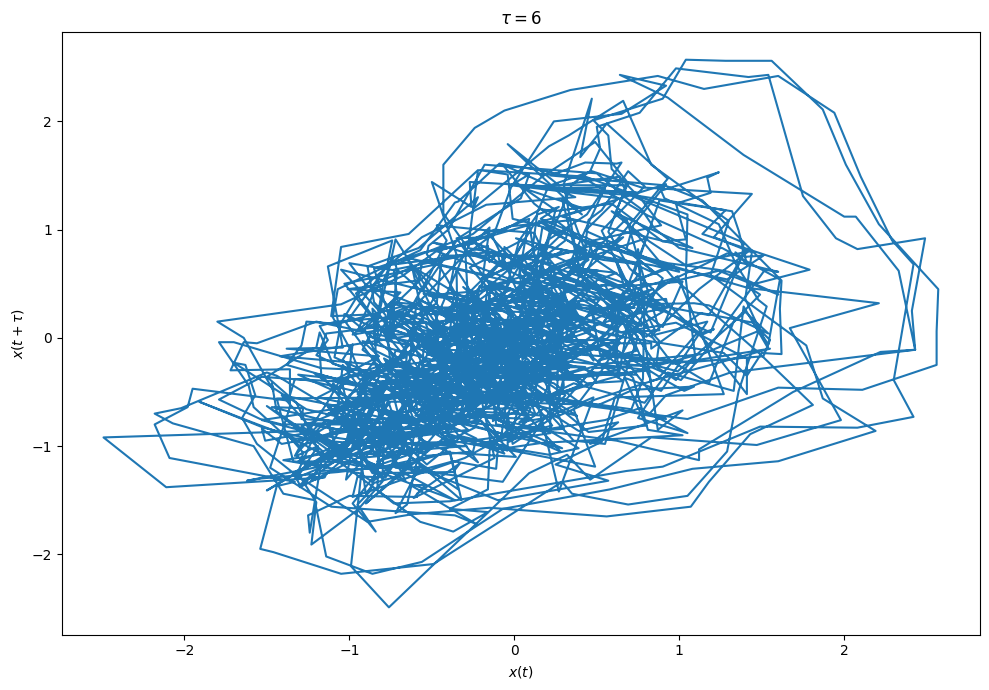

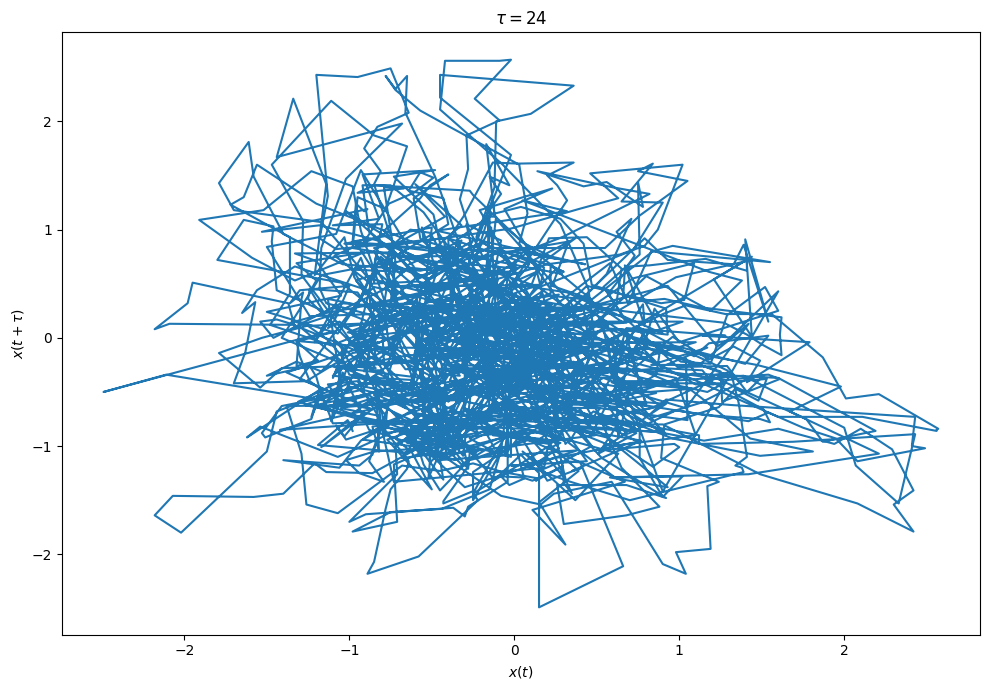

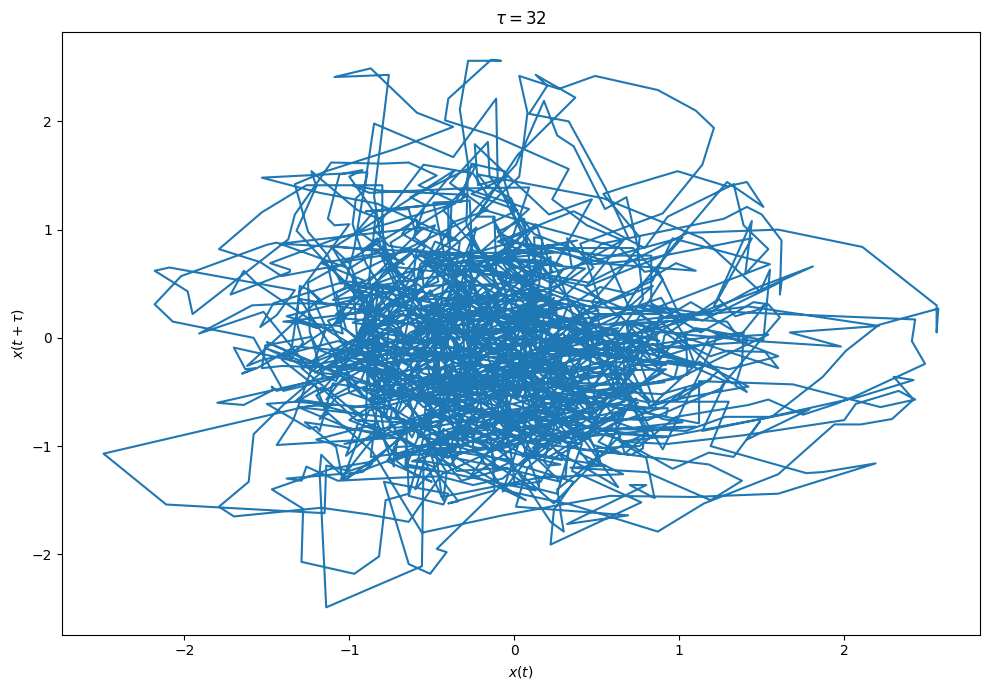

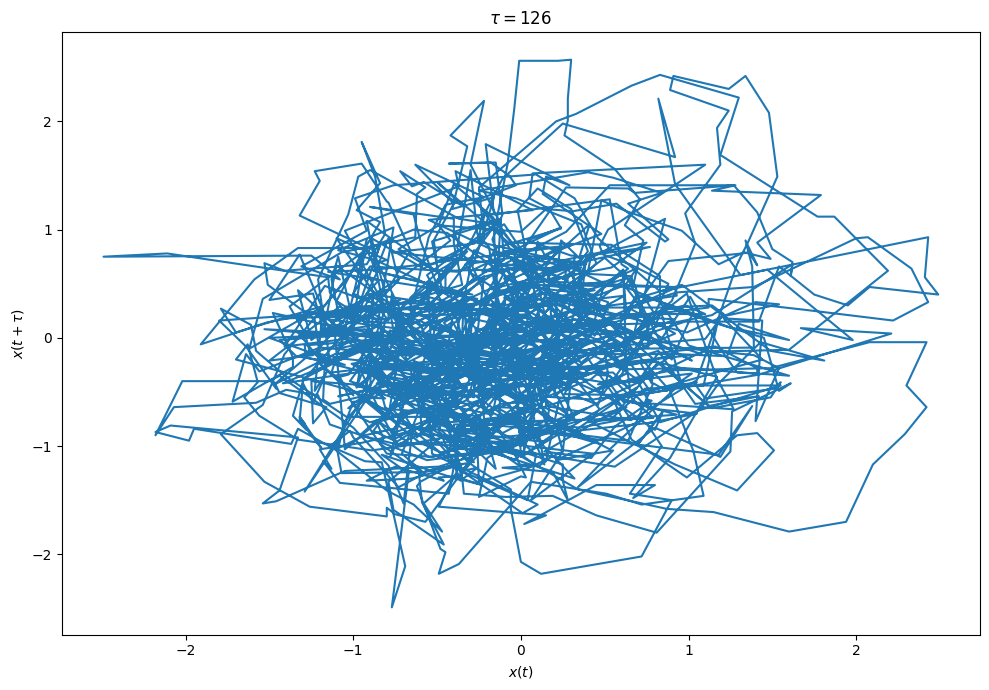

In [140]:
taus = [ 6, 24, 32, 126]

for tau in taus:
    return_map(flat_data, tau)



Plot the distribution of data values, calculate my, sigma, S, and K:

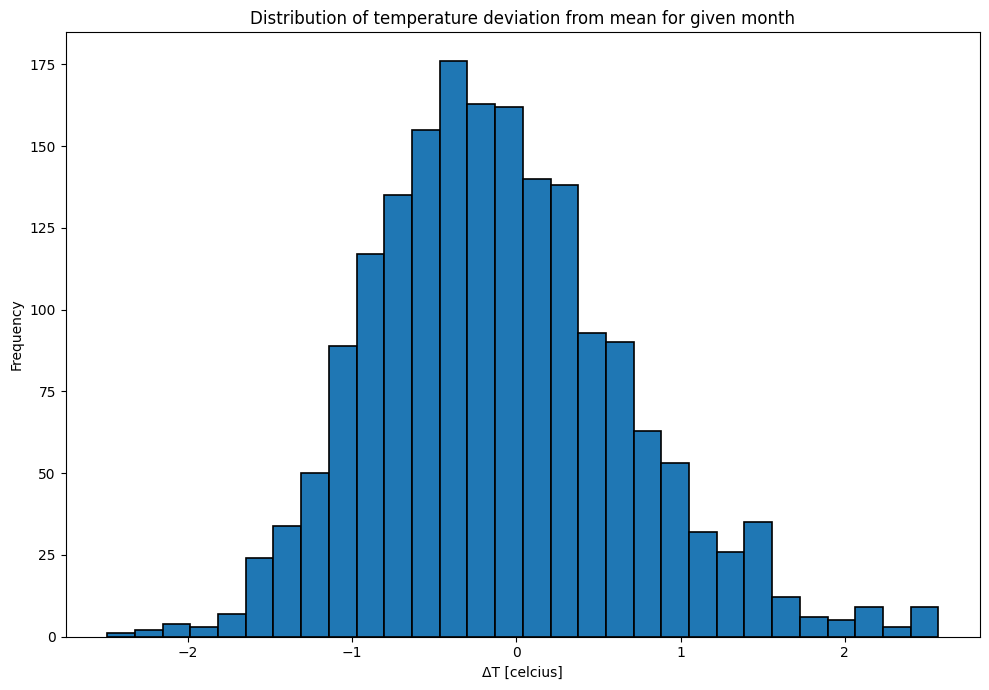

-0.10785403050108931
0.591669359956522
0.4713713415690935
0.4180523627779258
7.131865767246851


In [134]:


plt.hist(flat_data, 30, edgecolor='black', linewidth=1.2)
plt.xlabel('ΔT [celcius]')
plt.ylabel('Frequency')
plt.title("Distribution of temperature deviation from mean for given month")
plt.show()

S = np.std(flat_data)
median = np.median(flat_data)
mean = np.mean(flat_data)
variance = np.var(flat_data)
skewness = scipy.stats.skew(flat_data)
kurtosis = scipy.stats.kurtosis(flat_data)
CoV = S/abs(mean)
print(mean)
print(variance)
print(skewness)
print(kurtosis)
print(CoV)

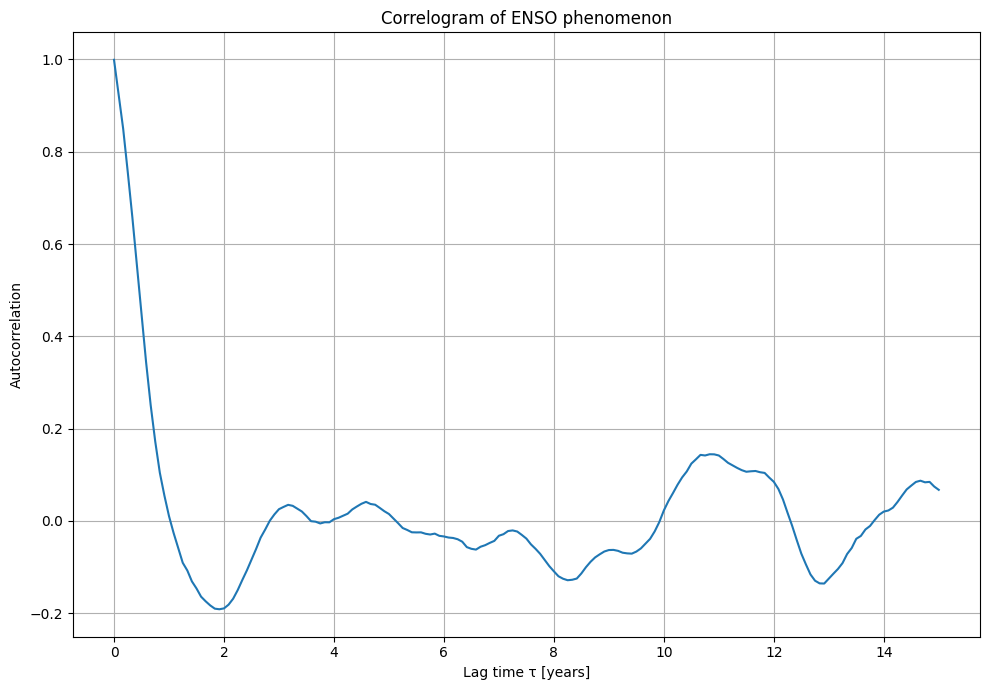

In [141]:
def ACF(ts, tau: int) -> float:

    N = len(ts)
    mean = np.mean(ts)
    std = np.std(ts)
    acf = 1 / ((std**2) *(N-tau)) * sum([(ts[t] - mean) * (ts[t+tau] - mean) for t in range(1, N-tau)])
    return acf

max_lag = 180
lags = np.arange(max_lag+1)
acf = np.zeros_like(lags, dtype=float)
for tau in lags:
    acf[tau] = np.mean(ACF(flat_data, tau))

# Plot autocorrelation vs. lag time
plt.plot(lags/12, acf)
plt.xlabel('Lag time τ [years]')
plt.ylabel('Autocorrelation')
plt.title('Correlogram of ENSO phenomenon')
plt.grid()
plt.show()

Calculate the PSD:

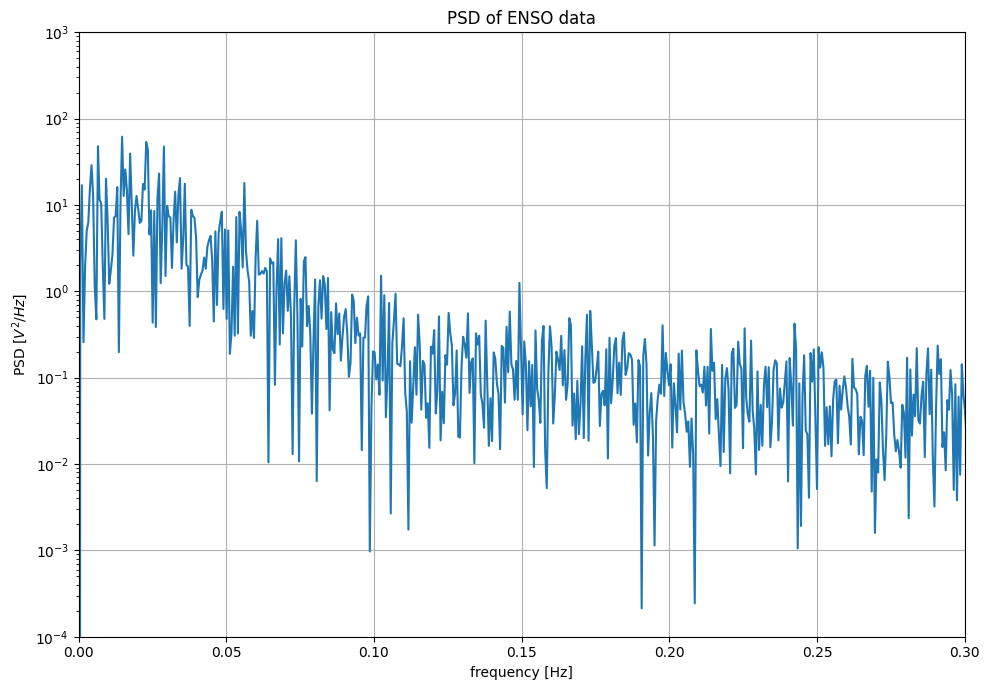

In [139]:
(f, S) = scipy.signal.periodogram(flat_data, 1, scaling='density')
plt.semilogy(f, S)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [$V^2/Hz$]')
plt.xlim(0,0.3)
plt.ylim(1e-4, 1e3)
plt.title("PSD of ENSO data")
plt.grid()
plt.show()

low_f_mask = f <= 0.1
high_f_mask = f > 0.1
low_f_S = S[low_f_mask]
high_f_S = S[high_f_mask]

low_f = f[low_f_mask]
high_f = f[high_f_mask]

# Find the indices of the two highest peaks in each region
low_f_indices = np.argsort(low_f_S)[::-1][:2]
high_f_indices = np.argsort(high_f_S)[::-1][:2]

# Get the peak frequencies in each region
low_f_peaks = low_f[low_f_indices]
high_f_peaks = high_f[high_f_indices]

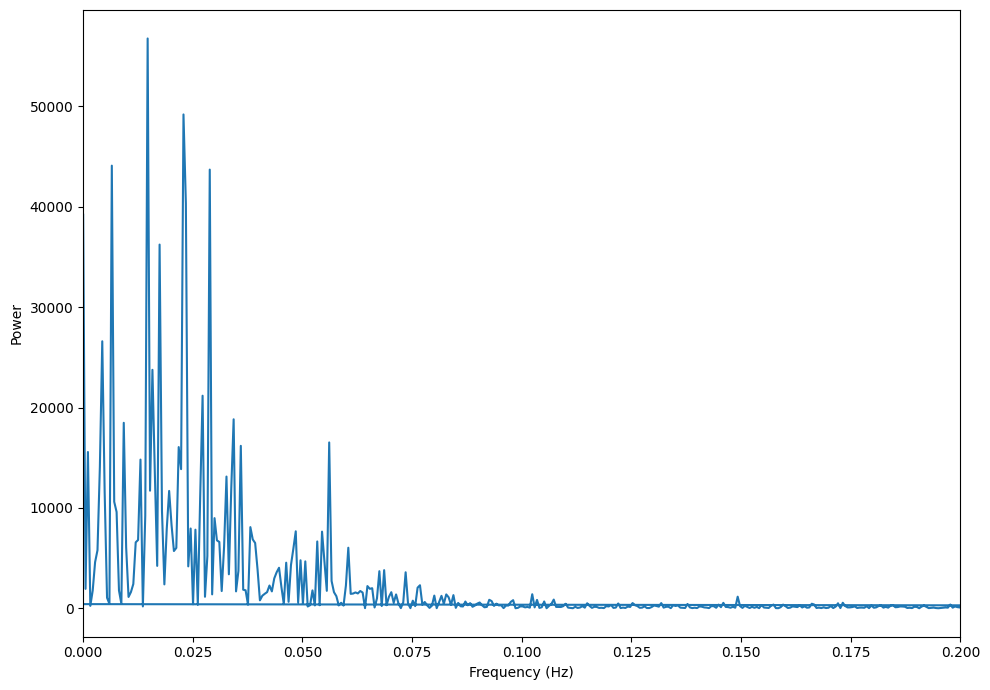

In [137]:
fft_data = fft(flat_data)
t = np.arange(len(flat_data))

# Compute the power spectrum
power_spectrum = np.abs(fft_data)**2

# Create the frequency axis
freq_axis = np.fft.fftfreq(len(flat_data), t[1] - t[0])

peak_freq = freq_axis[np.argmax(power_spectrum)]

# Plot the power spectrum
plt.plot(freq_axis, power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0,0.2)
plt.show()

In [138]:
print(1/peak_freq)

68.0


Reconstruct the attractor by using peaks from the PSD:

68
136


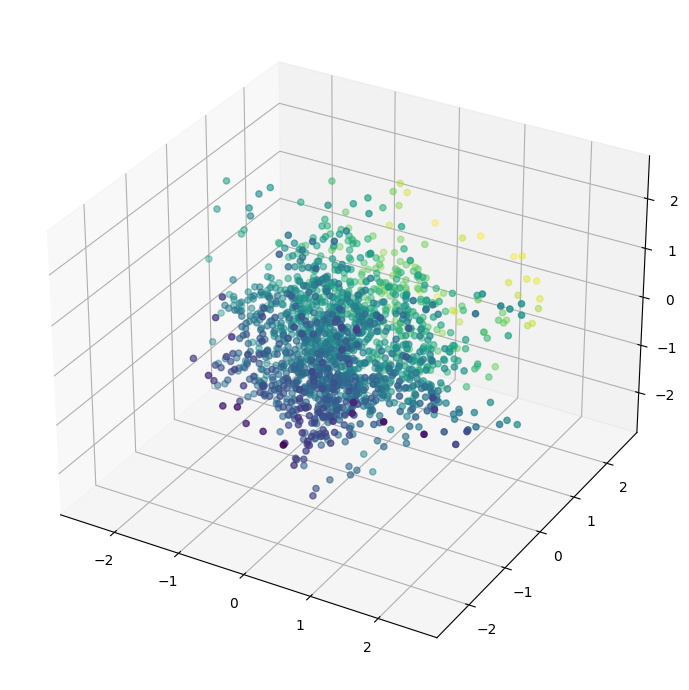

9
19


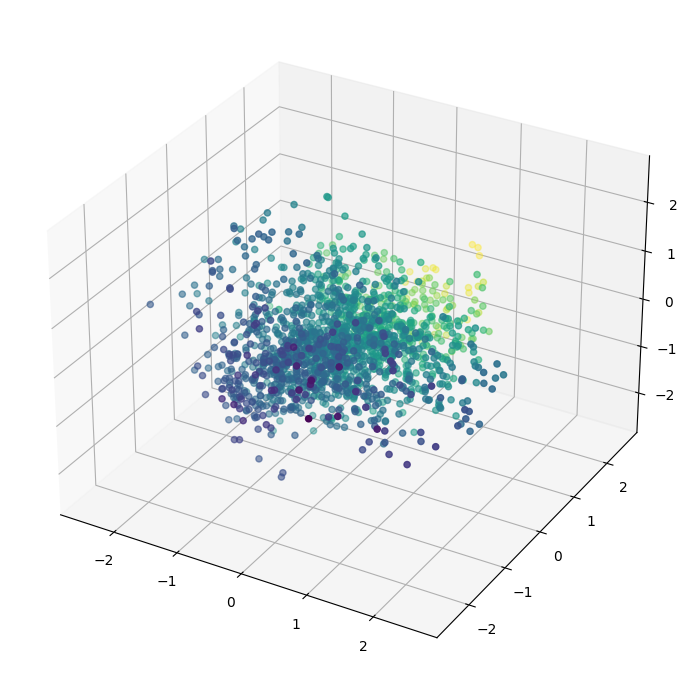

In [148]:

def attractor(ts, tau_1, tau_2):

    tau_1, tau_2 = [int(tau_1), int(tau_2)]
    print(tau_1)
    print(tau_2)
    ax = plt.axes(projection='3d')

    zline = ts[:-(tau_1 + tau_2)]
    xline = ts[tau_1:-(tau_2)]
    yline = ts[tau_2:-(tau_1)]
    ax.scatter3D(xline, yline, zline, c=yline, cmap='viridis')
    plt.show()

attractor(flat_data, 1/low_f_peaks[0], 2/low_f_peaks[0])
attractor(flat_data, 1/high_f_peaks[0], 2/high_f_peaks[0])


Comparison with gaussian noise:

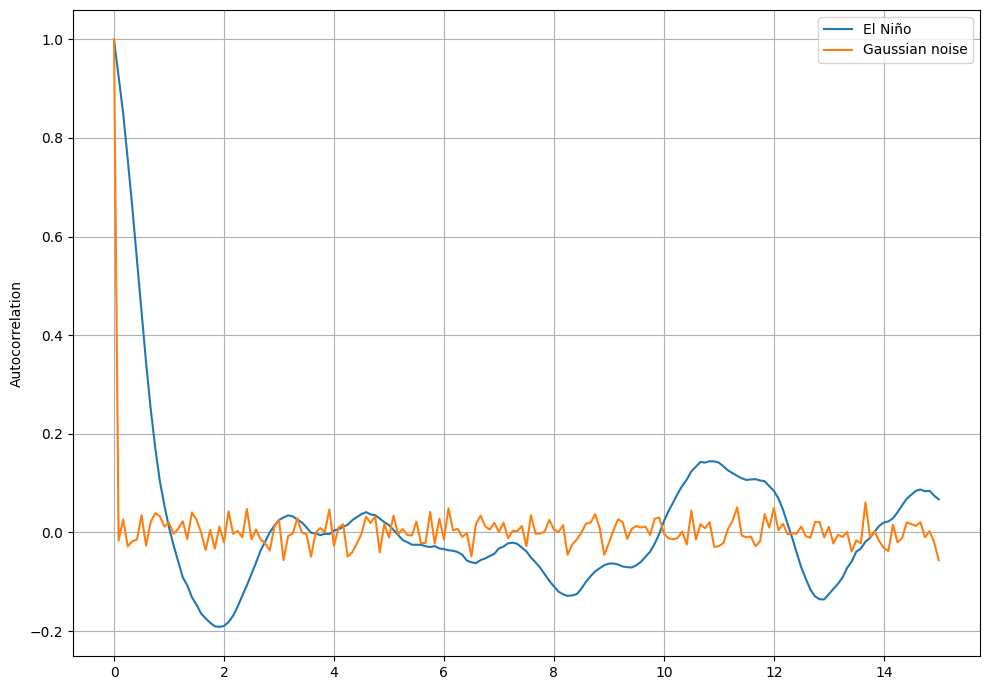

In [144]:
gaussian_noise = np.random.normal(-0.108, 0.592, size=len(flat_data))
max_lag = 180
lags = np.arange(max_lag+1)
acf_g = np.zeros_like(lags, dtype=float)
for tau in lags:
    acf_g[tau] = np.mean(ACF(gaussian_noise, tau))

# Plot autocorrelation vs. lag time
plt.plot(lags/12, acf, label="El Niño")
plt.plot(lags/12, acf_g, label="Gaussian noise")
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()



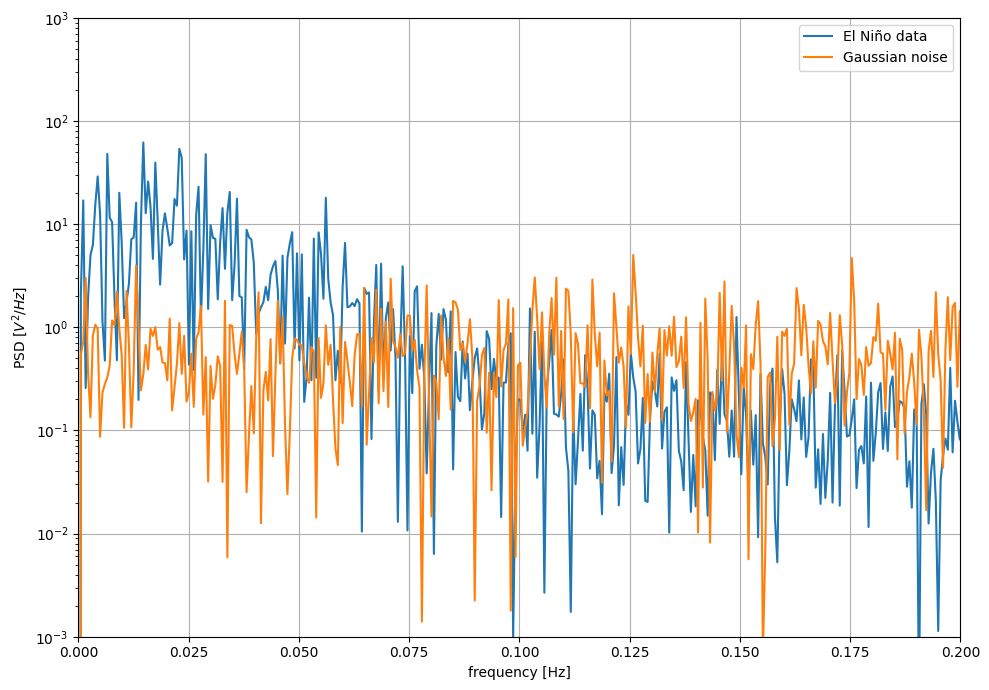

In [145]:
(fg, Sg) = scipy.signal.periodogram(flat_data, 1, scaling='density')
plt.semilogy(fg, Sg, label="El Niño data")

(f, S) = scipy.signal.periodogram(gaussian_noise, 1, scaling='density')
plt.semilogy(f, S, label="Gaussian noise")

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [$V^2/Hz$]')
plt.xlim(0,0.2)
plt.ylim(10e-4, 10e2)
plt.legend()
plt.grid()